In [1]:
%matplotlib inline
from prophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = 9, 6

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv')
df.set_index('ds').plot()

<Axes: xlabel='ds'>

In [3]:
m = Prophet()
m = m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)

16:28:23 - cmdstanpy - INFO - Chain [1] start processing
16:28:23 - cmdstanpy - INFO - Chain [1] done processing


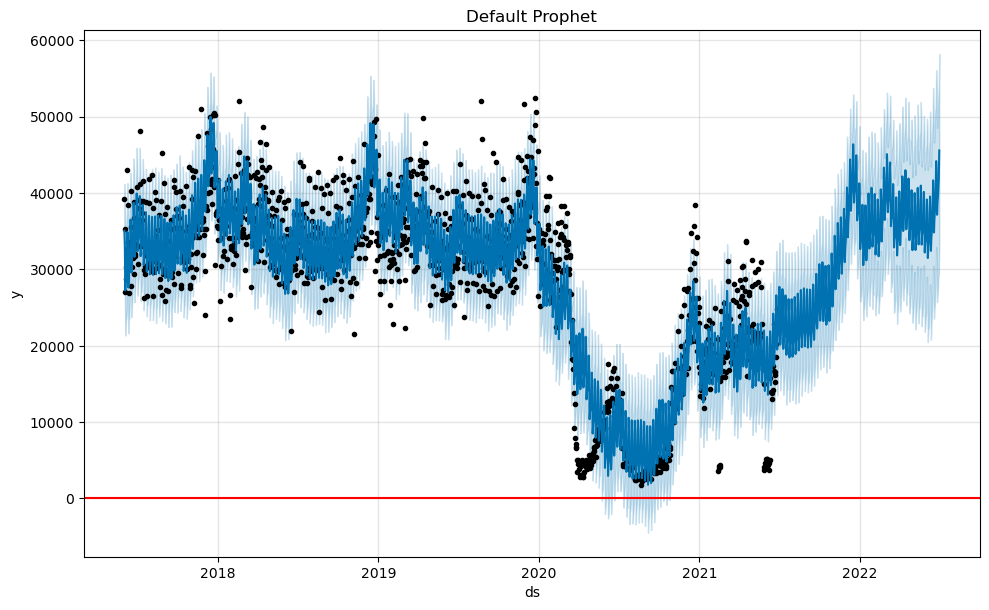

In [12]:
m.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Default Prophet');
plt.show()

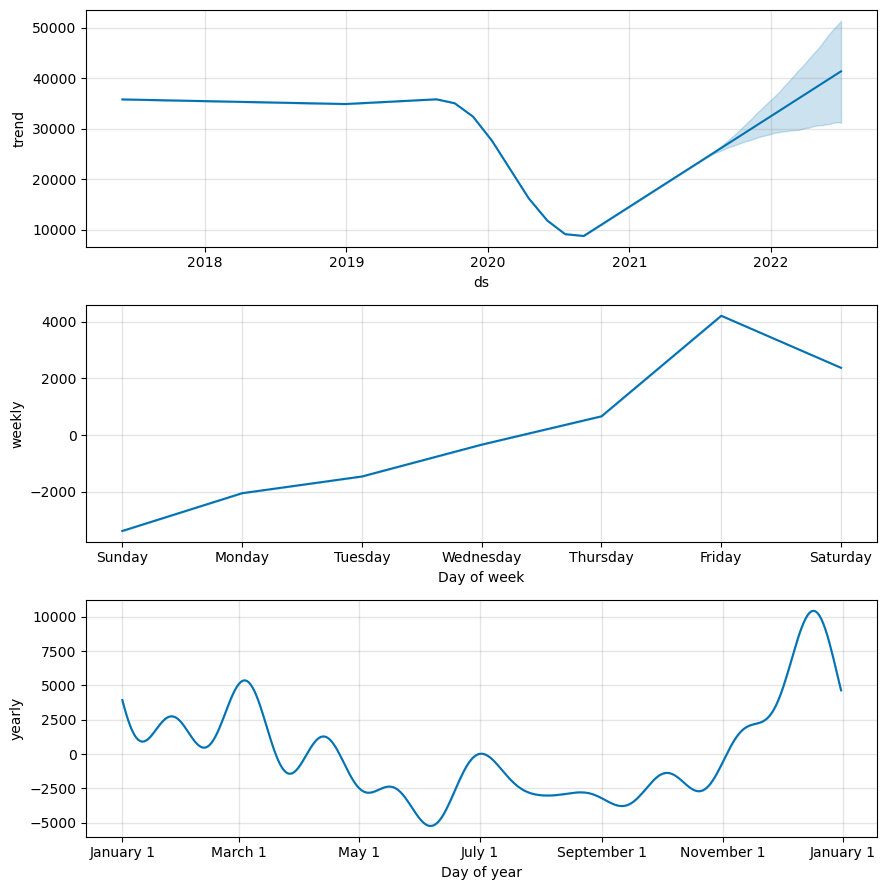

In [11]:
m.plot_components(forecast);
plt.show()


In [6]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [7]:
m2 = Prophet(holidays=lockdowns)
m2 = m2.fit(df)
future2 = m2.make_future_dataframe(periods=366)
forecast2 = m2.predict(future2)

16:32:12 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing


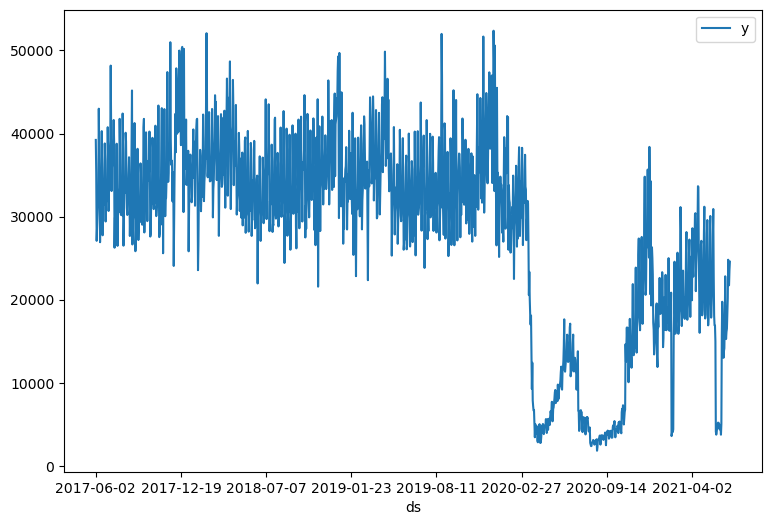

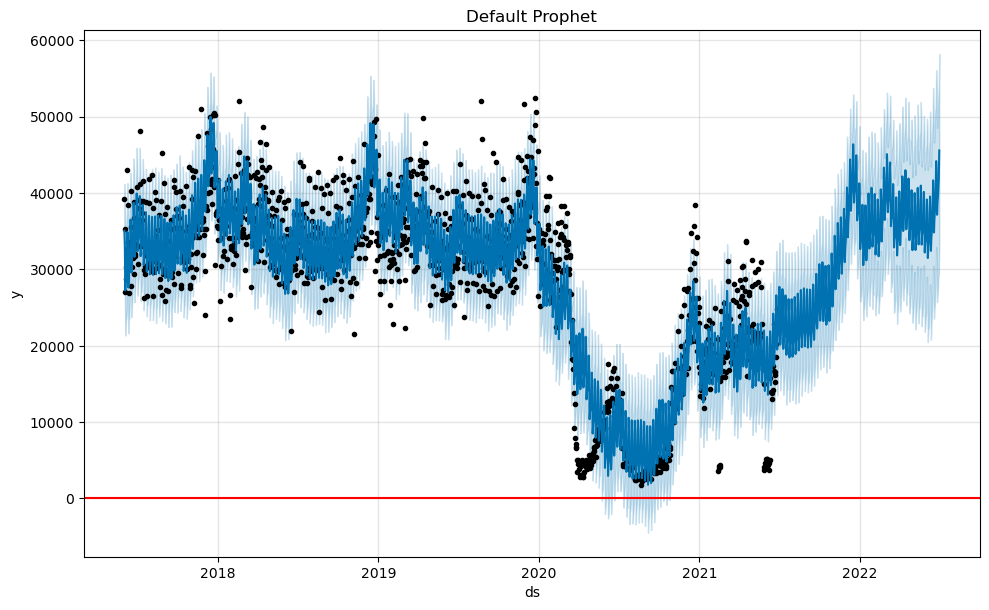

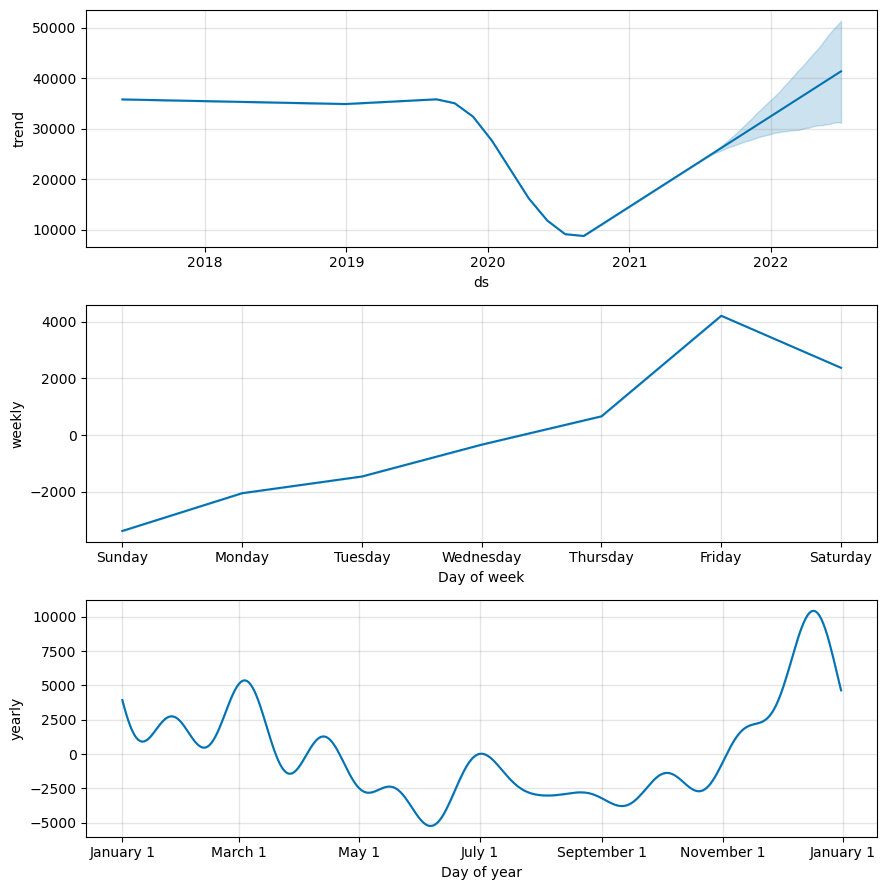

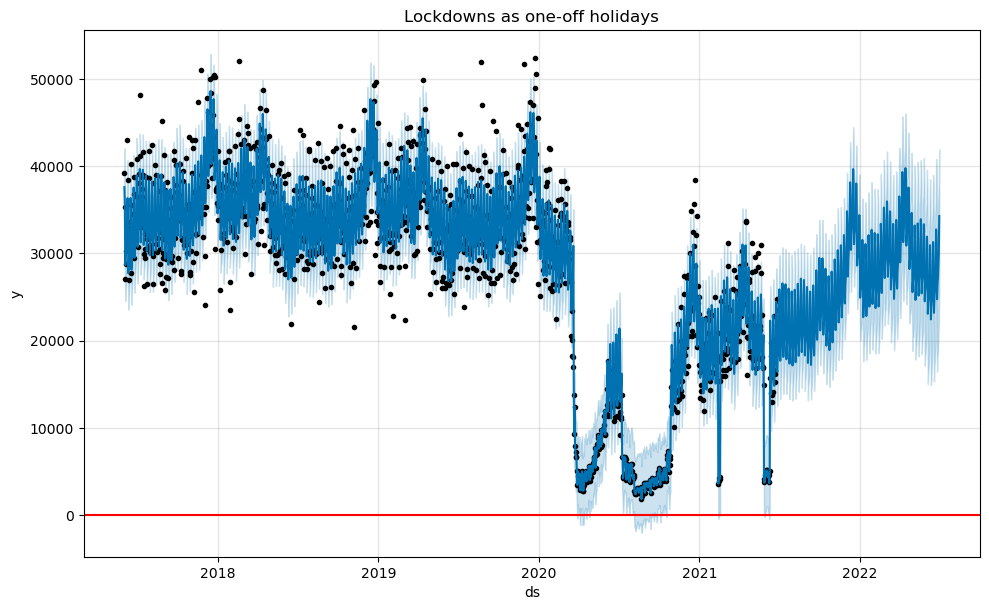

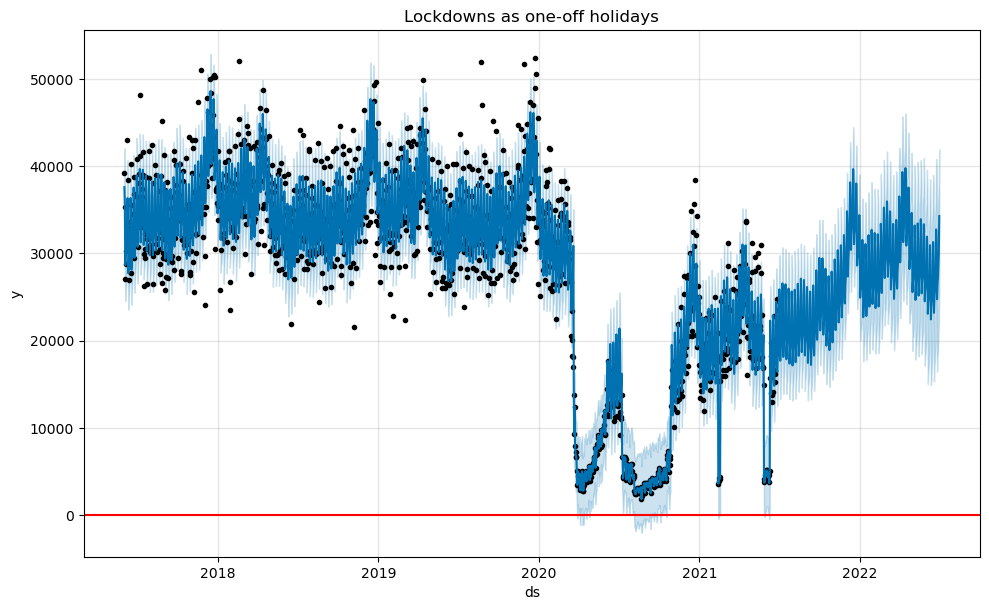

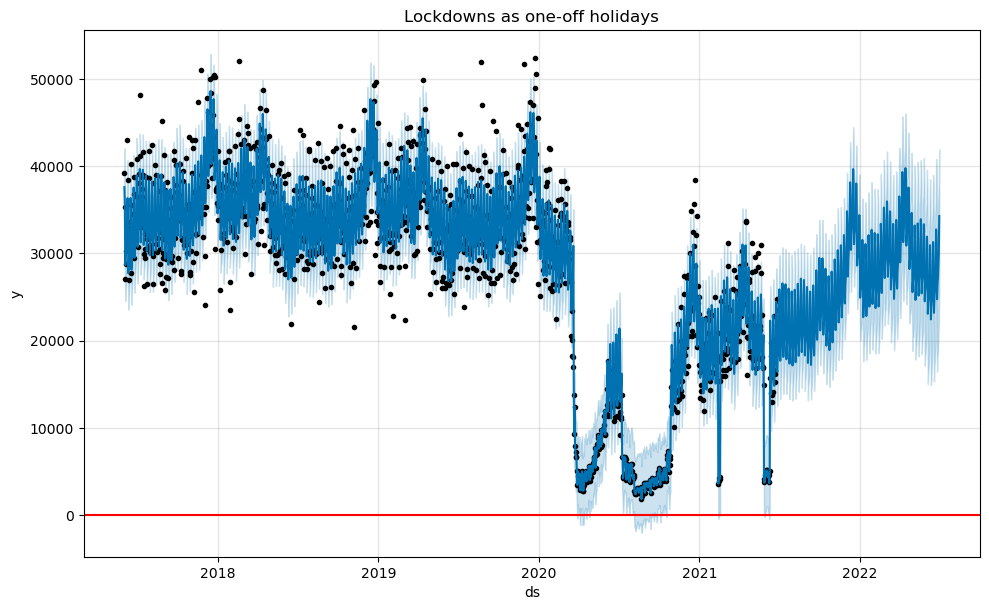

In [10]:
m2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');
plt.show()

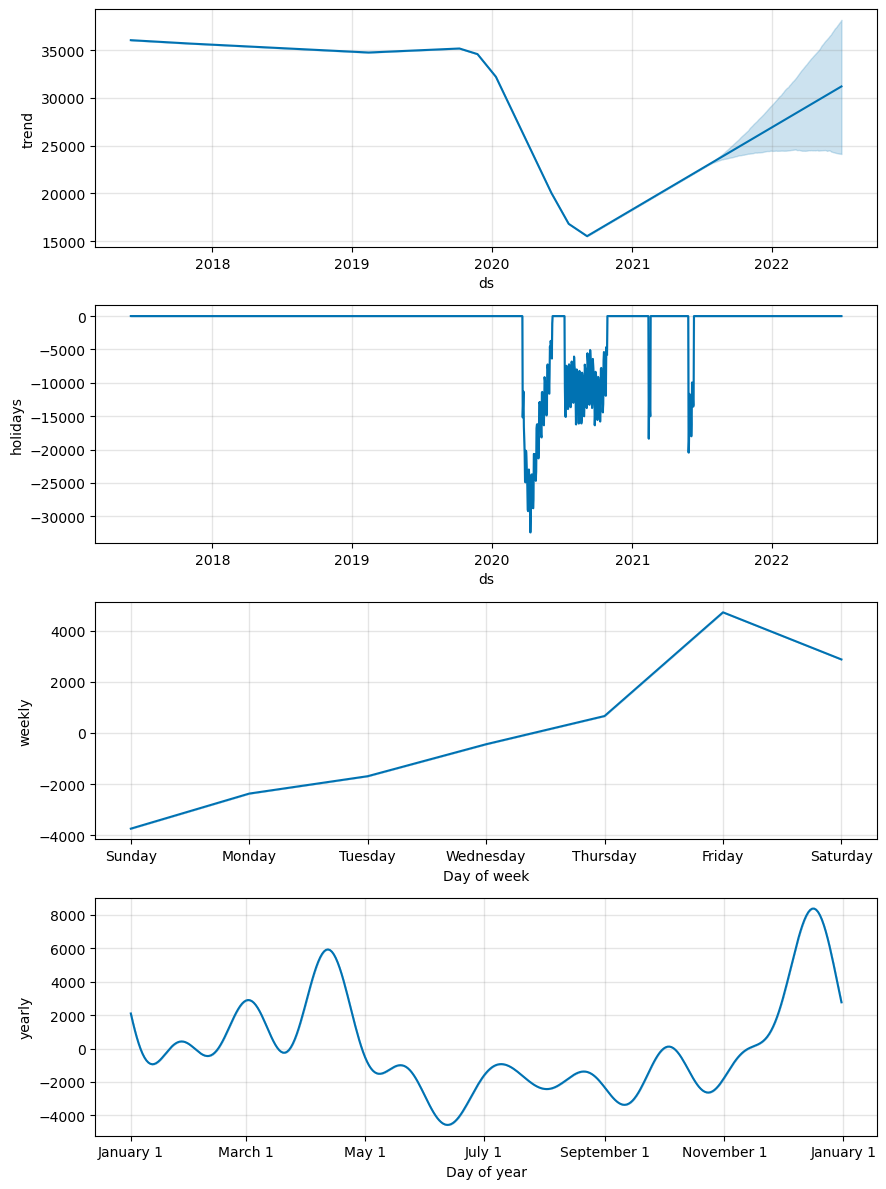

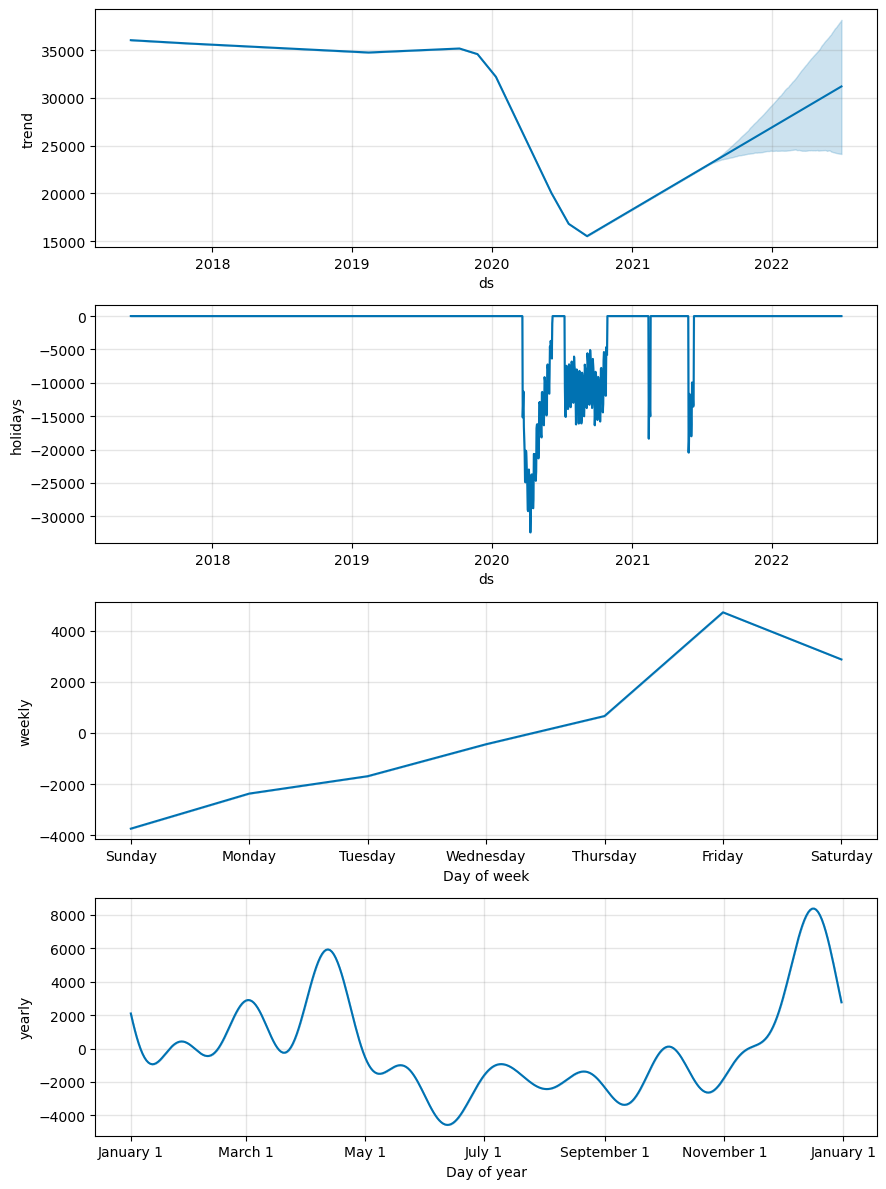

In [14]:
m2.plot_components(forecast2);
plt.show()

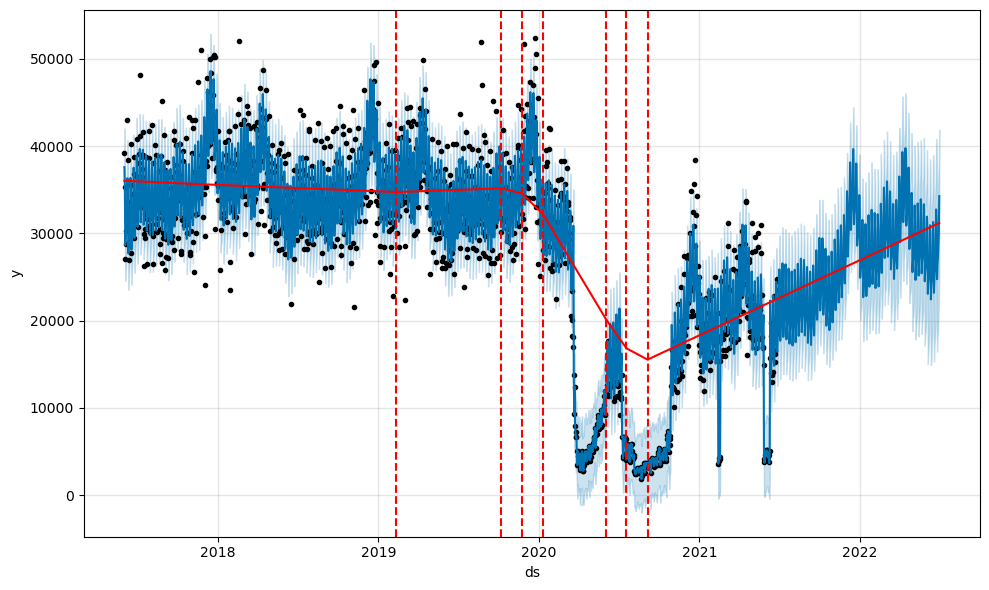

In [15]:
from prophet.plot import add_changepoints_to_plot
fig = m2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)
plt.show()

In [16]:
m3_changepoints = (
    # 10 potential changepoints in 2.5 years
    pd.date_range('2017-06-02', '2020-01-01', periods=10).date.tolist() + 
    # 15 potential changepoints in 1 year 2 months
    pd.date_range('2020-02-01', '2021-04-01', periods=15).date.tolist()
)
# Default changepoint_prior_scale is 0.05, so 1.0 will lead to much more flexibility in comparison.
m3 = Prophet(holidays=lockdowns, changepoints=m3_changepoints, changepoint_prior_scale=1.0)
m3 = m3.fit(df)
forecast3 = m3.predict(future2)

16:39:59 - cmdstanpy - INFO - Chain [1] start processing
16:40:00 - cmdstanpy - INFO - Chain [1] done processing


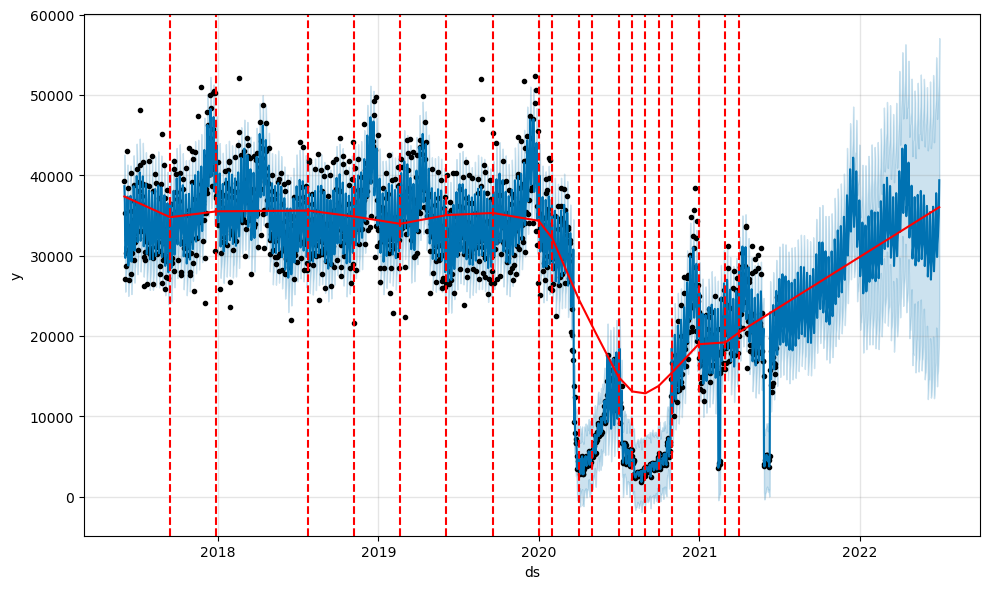

In [17]:
from prophet.plot import add_changepoints_to_plot
fig = m3.plot(forecast3)
a = add_changepoints_to_plot(fig.gca(), m3, forecast3)
plt.show()

In [19]:
df2 = df.copy()
df2['pre_covid'] = pd.to_datetime(df2['ds']) < pd.to_datetime('2020-03-21')
df2['post_covid'] = ~df2['pre_covid']

In [20]:
m4 = Prophet(holidays=lockdowns, weekly_seasonality=False)
m4.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m4.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
);

In [21]:
m4 = m4.fit(df2)


16:43:55 - cmdstanpy - INFO - Chain [1] start processing
16:43:56 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future4 = m4.make_future_dataframe(periods=366)
future4['pre_covid'] = pd.to_datetime(future4['ds']) < pd.to_datetime('2020-03-21')
future4['post_covid'] = ~future4['pre_covid']

In [23]:
forecast4 = m4.predict(future4)

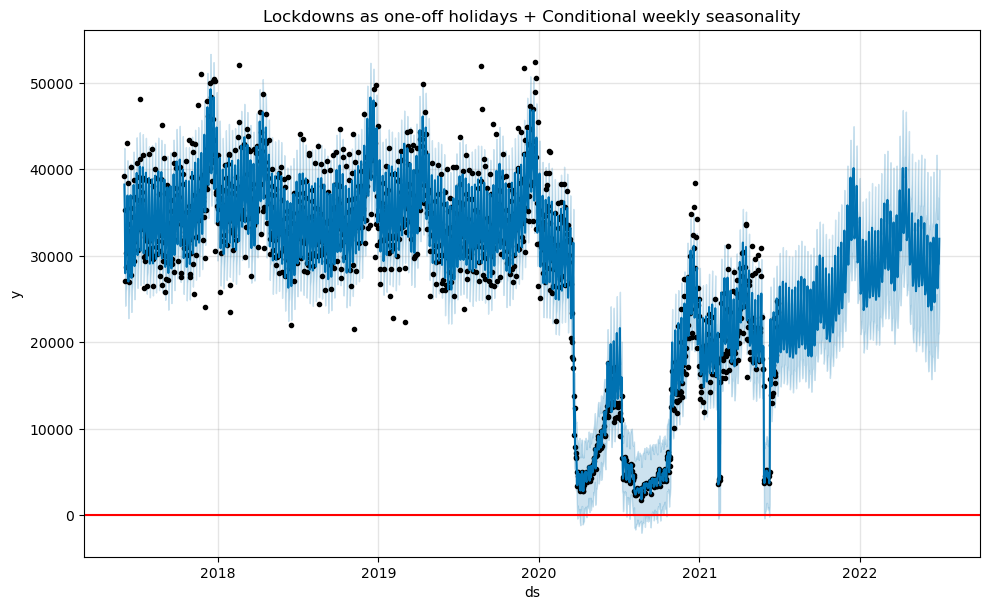

In [24]:
m4.plot(forecast4)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays + Conditional weekly seasonality');
plt.show()

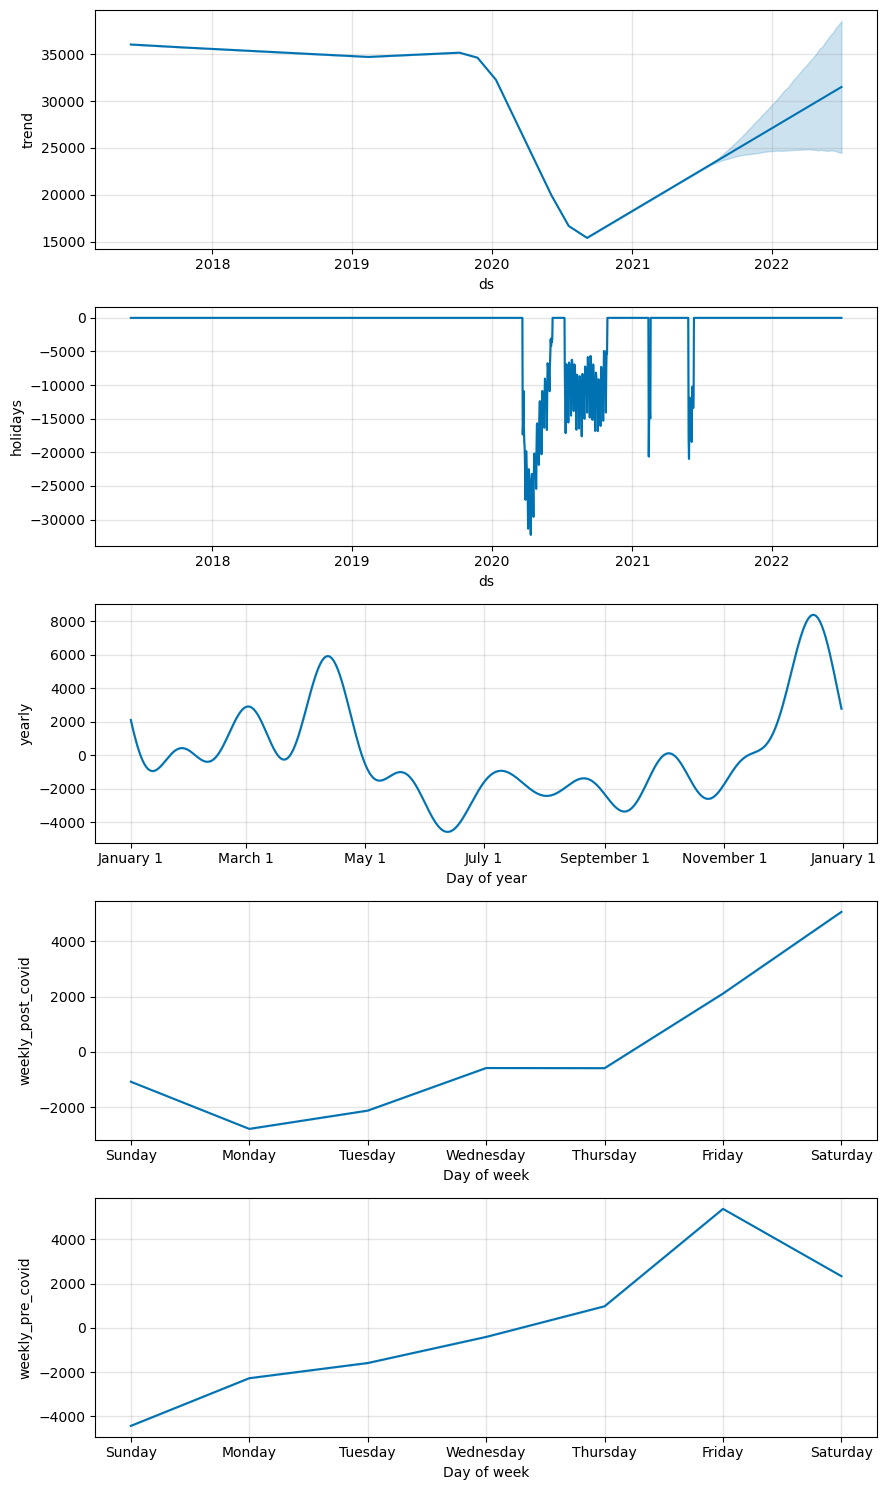

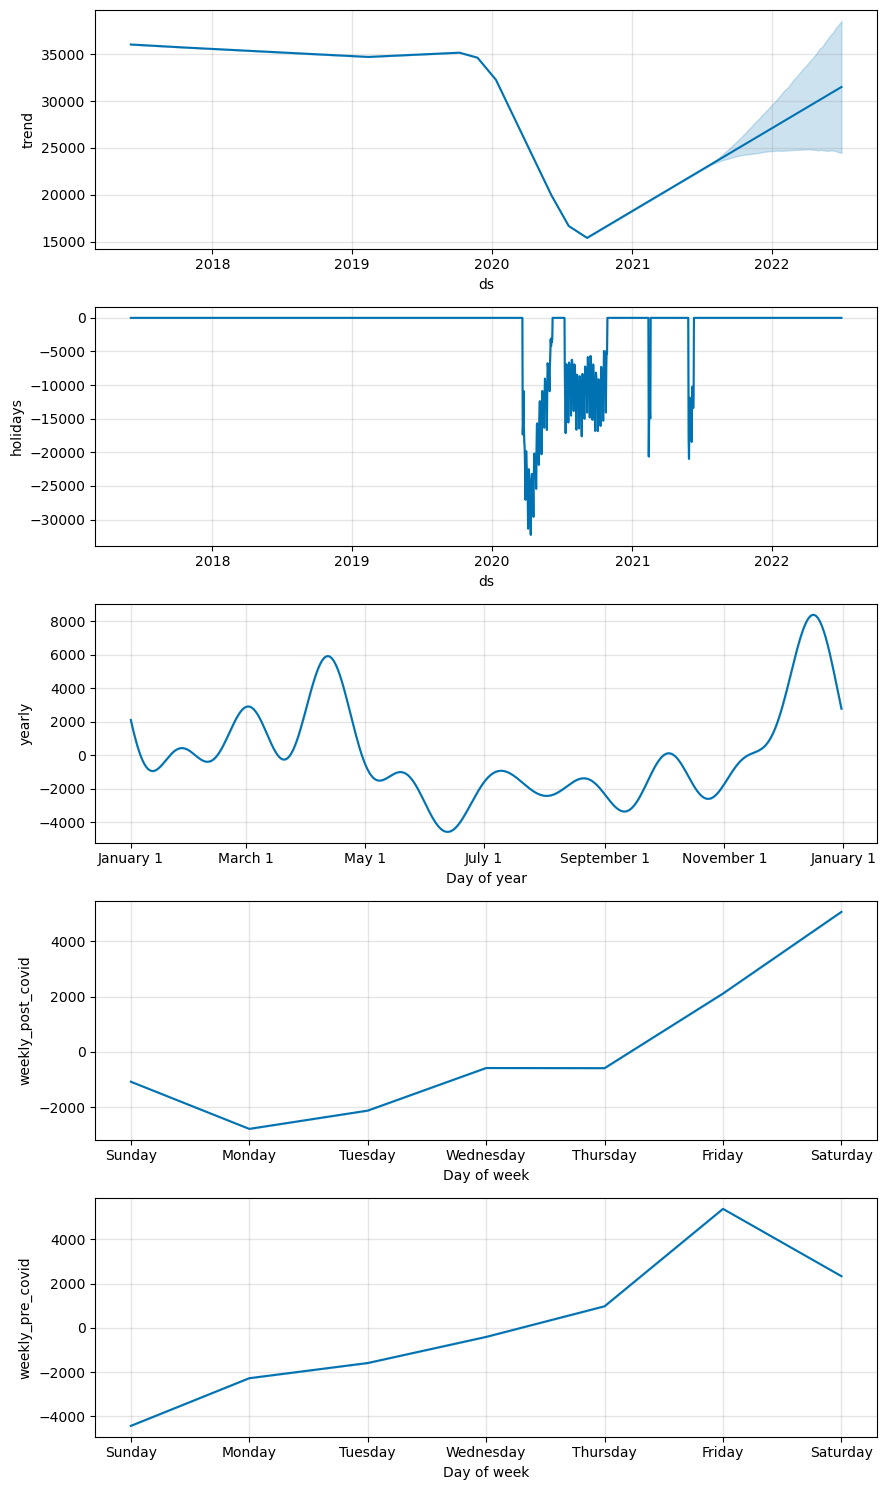

In [26]:
m4.plot_components(forecast4);
plt.show()

In [27]:
from prophet.serialize import model_to_json, model_from_json

with open('models/serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('models/serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model